### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("train.csv")
data=np.array(data)
m,n=data.shape
np.random.shuffle(data)
data_dev=data[0:1000].T
x_dev=data_dev[1:n]
y_dev=data_dev[0]
x_dev=x_dev/255.

In [3]:
data_train=data[1000:m].T
x_train=data_train[1:n]
y_train=data_train[0]
x_train=x_train/255.


In [4]:
x_train.shape,x_dev.shape,y_train.shape,y_dev.shape

((784, 41000), (784, 1000), (41000,), (1000,))

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

Thanks to <a href="https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras/notebook">Samson Zhang</a>

In [5]:
def init_params():
    w1=np.random.rand(10,784)-0.5
    b1=np.random.rand(10,1)-0.5
    w2=np.random.rand(10,10)-0.5
    b2=np.random.rand(10,1)-0.5
    return w1,b1,w2,b2
def relu(Z):
    return np.maximum(Z,0)
def softmax(Z):
    ans=np.exp(Z)/sum(np.exp(Z))
    return ans

In [6]:
def forward(w1,b1,w2,b2,X):
    z1=w1.dot(X)+b1
    a1=relu(z1)
    z2=w2.dot(a1)+b2
    a2=relu(z2)
    # print("shape a1 and a2",a1.shape,a2.shape)
    return z1,a1,z2,a2

def reLU_deriv(z):
    return z>0

def one_hot(y):
    one_hot_Y=np.zeros((y.size,y.max()+1))
    one_hot_Y[np.arange(y.size), y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward(X,y,a1,a2,w1,w2,z1,z2):
    dz_2=a2-one_hot(y) #(10,41000)
    dw_2=1/m*(dz_2.dot(a1.T)) #(10,10)
    db_2=1/m*np.sum(dz_2) #(10,1)
    dz_1=w2.T.dot(dz_2) * reLU_deriv(z1) #(10,41000)
    dw_1 = 1 / m * dz_1.dot(X.T) #(10,10)
    db_1 = 1 / m * np.sum(dz_1) #(10,1)
    return dw_1,dw_2,db_1,db_2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [7]:
w1,b1,w2,b2=init_params()
z1,a1,z2,a2=forward(w1,b1,w2,b2,x_train)

### Training

In [8]:
def predictions(pred):
    return np.argmax(pred,0)

def accuracy(pred,y):
    print("pred:{} ,y:{} ".format(pred,y))
    print("accuracy: ",np.sum(pred==y)/y.size)
    
def training(x_train,y_train,alpha,epochs):
    w1,b1,w2,b2=init_params()
    for epoch in range(epochs):
        z1,a1,z2,a2=forward(w1,b1,w2,b2,x_train)
        dw_1,dw_2,db_1,db_2=backward(x_train,y_train,a1,a2,w1,w2,z1,z2)
        w1, b1, w2, b2=update_params(w1, b1, w2, b2, dw_1, db_1, dw_2, db_2, alpha)
        if epoch%10==0:
            print("epoch: ", epoch)
            pred=predictions(a2)
            print(accuracy(pred,y_train))
    return w1,b1,w2,b2

In [14]:
w1,b1,w2,b2 = training(x_train, y_train, 0.172, 500)

epoch:  0
pred:[6 9 6 ... 9 6 1] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.08119512195121951
None
epoch:  10
pred:[8 8 9 ... 9 8 0] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.14165853658536584
None
epoch:  20
pred:[8 8 9 ... 9 8 0] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.15173170731707317
None
epoch:  30
pred:[6 8 4 ... 9 8 0] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.17370731707317072
None
epoch:  40
pred:[6 8 4 ... 9 8 0] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.19597560975609757
None
epoch:  50
pred:[6 8 4 ... 0 8 0] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.22195121951219512
None
epoch:  60
pred:[6 8 4 ... 0 8 0] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.25165853658536586
None
epoch:  70
pred:[6 8 4 ... 0 8 0] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.2809268292682927
None
epoch:  80
pred:[6 8 4 ... 4 8 0] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.3046829268292683
None
epoch:  90
pred:[6 8 4 ... 4 8 0] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.3232439024390244
None
epoch:  100
pred:[6 8 4 ... 9 8 0] ,y:[8 5 4 ... 9 1 0] 
accuracy:  0.34234146341463

### Testing

In [40]:
labels=list(pd.Series(y_train).unique())
labels.sort()
labels=labels
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [15]:
def make_predictions(x,w1,b1,w2,b2):
    _,_,_,a2=forward(w1,b1,w2,b2,x)
    pred=predictions(a2)
    return pred

def test_prediction(index,w1,b1,w2,b2):
    test_ex=x_dev[:,index,None]
    pred=make_predictions(test_ex,w1,b1,w2,b2)
    print("prediction:{} ,label:{}".format(pred,y_dev[index]))
    
    curr_img=test_ex.reshape(28,28)*255
    plt.gray()
    plt.imshow(curr_img,interpolation="nearest")
    plt.show()

prediction:[6] ,label:5


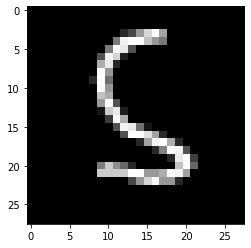

prediction:[4] ,label:4


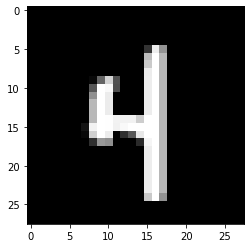

In [16]:
test_prediction(0, w1,b1,w2,b2)
test_prediction(1, w1,b1,w2,b2)

prediction:[2] ,label:2


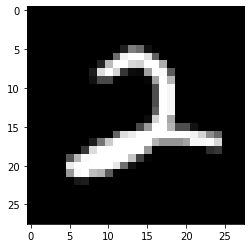

prediction:[3] ,label:8


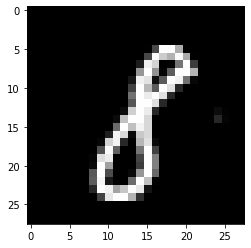

prediction:[0] ,label:0


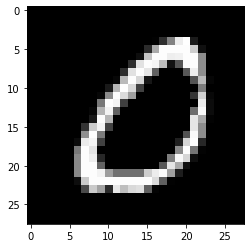

prediction:[4] ,label:4


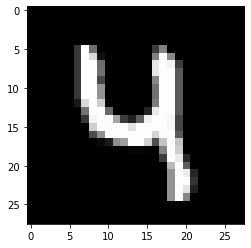

In [43]:
test_prediction(12, w1,b1,w2,b2)
test_prediction(11, w1,b1,w2,b2)
test_prediction(80, w1,b1,w2,b2)
test_prediction(13, w1,b1,w2,b2)